# UFC Retirement Age - Modeling

## 1. Contents<a id='1._Contents'></a>
* [UFC Retirement Age - Modeling](#UFC_Retirement_Age_-_Modeling)
  * [1. Contents](#1._Contents)
  * [2. Sourcing and Loading](#2._Sourcing_and_Loading)
    * [2a. Import relevant libraries](#2a._Import_relevant_libraries)
    * [2b. Load previously preprocessed DataFrame](#2b._Load_previously_preprocessed_DataFrame)
    * [2c. Preliminary exploration of data](#2c._Preliminary_exploration_of_data)
  * [3. Additional Data Wrangling](#3._Additional_Data_Wrangling)
    * [3a. Bout columns](#3a._Bout_columns)
    * [3b. Isolating X and y columns](#3b._Isolating_X_and_y_columns)
    * [3c. Removing null columns](#3c._Removing_null_columns)
    * [3d. Remove outlier row](#3e._Remove_outlier_row)
  * [4. Modeling](#4._Modeling)
    * [4a. Comparing multivariate linear regression with model based on mean](#4a._Finding_best_features_for_linear_regression_model)
    * [4b. `Winner` based on `age`](#4b._Finding_best_features_for_random_forest_regressor)
    * [4c. `Winner` based on `age_dif`](#4c._Choosing_best_model)
    * [4d. `Winner` vs. every column](#4c._Choosing_best_model)
  * [5. Conclusion](#5._Conclusion)

## 2. Sourcing and Loading<a id='2._Sourcing_and_Loading'></a>

**2a. Import relevant libraries** <a id='2a._Import_relevant_libraries'></a>

In [154]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle as kg
import pandas as pd
import missingno as msno
import statsmodels.api as sm
import scipy.stats
from matplotlib.lines import Line2D
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, \
plot_roc_curve, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, preprocessing
from zipfile import ZipFile
from scipy import stats
from scipy.stats import t
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from numpy.random import seed
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

**2b. Load previously preprocessed DataFrame** <a id='2b._Load_previously_preprocessed_DataFrame'></a>

In [178]:
df = pd.read_csv('df.csv', index_col=0)
df.head()

,date,fighter,odds,Winner,title_bout,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,...,weight_class_Middleweight,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,gender_MALE,Stance_Orthodox,Stance_Southpaw,Stance_Switch
0,2020-10-03,Holly Holm,-125,1,0,0,1,0,2.75,0.35,...,0,0,1,0,0,0,0,0,1,0
1,2020-10-03,Irene Aldana,103,0,0,0,2,0,6.16,0.38,...,0,0,1,0,0,0,0,1,0,0
2,2020-10-03,Yorgan De Castro,-265,0,0,1,0,0,2.19,0.41,...,0,0,0,0,0,0,1,1,0,0
3,2020-10-03,Carlos Felipe,205,1,0,1,0,0,2.93,0.36,...,0,0,0,0,0,0,1,1,0,0
4,2020-10-03,Germaine de Randamie,-150,1,0,1,0,0,2.72,0.47,...,0,0,1,0,0,0,0,1,0,0


**2c. Preliminary exploration of data** <a id='2c._Preliminary_exploration_of_data'></a>

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8816 entries, 0 to 8815
Columns: 103 entries, date to Stance_Switch
dtypes: float64(29), int64(72), object(2)
memory usage: 7.0+ MB


In [179]:
df.shape

(8816, 103)

In [158]:
df.columns

Index(['date', 'fighter', 'odds', 'Winner', 'title_bout',
       'current_lose_streak', 'current_win_streak', 'draw',
       'avg_SIG_STR_landed', 'avg_SIG_STR_pct',
       ...
       'weight_class_Middleweight', 'weight_class_Welterweight',
       'weight_class_Women's Bantamweight',
       'weight_class_Women's Featherweight', 'weight_class_Women's Flyweight',
       'weight_class_Women's Strawweight', 'gender_MALE', 'Stance_Orthodox',
       'Stance_Southpaw', 'Stance_Switch'],
      dtype='object', length=103)

# 3. Additional Data Wrangling <a id='3._Additional_Data_Wrangling'></a>

**3a. Bout columns** <a id='3a._Bout_columns'></a>

Many of the bout columns provide stats on the entire bout, but since some fights end in the first round and others can go all 5 rounds, these columns would be much more helpful to us if they gave us an average over the seconds spent in the fight. 

In [180]:
bout_data = [column for column in df.columns if column.endswith(('d_bout','s_bout','v_bout'))]
bout_data

['kd_bout',
 'sig_str_landed_bout',
 'sig_str_attempted_bout',
 'tot_str_landed_bout',
 'tot_str_attempted_bout',
 'td_landed_bout',
 'td_attempted_bout',
 'sub_attempts_bout',
 'pass_bout',
 'rev_bout']

In [181]:
for column in df[bout_data].columns:
    df[column] = df[column] / df['total_fight_time_secs']
    
df[bout_data].describe()

,kd_bout,sig_str_landed_bout,sig_str_attempted_bout,tot_str_landed_bout,tot_str_attempted_bout,td_landed_bout,td_attempted_bout,sub_attempts_bout,pass_bout,rev_bout
count,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000
mean,0.001265,0.062168,0.137246,0.086543,0.165105,0.001710,0.004524,0.000890,0.001871,0.000218
std,0.006181,0.054308,0.092434,0.062350,0.094618,0.002944,0.005811,0.002817,0.003806,0.001217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.031111,0.076706,0.048889,0.103433,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.051111,0.121111,0.074266,0.151111,0.000000,0.002661,0.000000,0.000000,0.000000
75%,0.000000,0.077778,0.176287,0.107778,0.204372,0.002222,0.006667,0.000000,0.002222,0.000000
max,0.142857,0.857143,1.428571,0.857143,1.428571,0.041667,0.068966,0.071429,0.058824,0.071429


In [182]:
secs_data = [column.replace('_bout', '_per_sec') for column in bout_data]
secs_data

['kd_per_sec',
 'sig_str_landed_per_sec',
 'sig_str_attempted_per_sec',
 'tot_str_landed_per_sec',
 'tot_str_attempted_per_sec',
 'td_landed_per_sec',
 'td_attempted_per_sec',
 'sub_attempts_per_sec',
 'pass_per_sec',
 'rev_per_sec']

In [183]:
for bout_column, secs_column in zip(bout_data, secs_data):
    df.rename({bout_column: secs_column}, axis=1, inplace=True)

df[secs_data].tail()

,kd_per_sec,sig_str_landed_per_sec,sig_str_attempted_per_sec,tot_str_landed_per_sec,tot_str_attempted_per_sec,td_landed_per_sec,td_attempted_per_sec,sub_attempts_per_sec,pass_per_sec,rev_per_sec
8811,0.0,0.042553,0.127660,0.042553,0.127660,0.000000,0.042553,0.000000,0.000000,0.000000
8812,0.0,0.043333,0.084444,0.100000,0.145556,0.006667,0.011111,0.000000,0.006667,0.000000
8813,0.0,0.018889,0.068889,0.034444,0.084444,0.000000,0.000000,0.000000,0.000000,0.000000
8814,0.0,0.030000,0.090000,0.057778,0.118889,0.002222,0.003333,0.001111,0.001111,0.001111
8815,0.0,0.077778,0.161111,0.144444,0.228889,0.003333,0.006667,0.001111,0.006667,0.001111


**3b. Isolating X and y columns** <a id='3b._Isolating_X_and_y_columns'></a>

`age` is going to be our dependent variable, while our independent variables are going to be based on fight performance.

In [185]:
fight_perf = ['Winner','finish'] + secs_data
fight_perf

['Winner',
 'finish',
 'kd_per_sec',
 'sig_str_landed_per_sec',
 'sig_str_attempted_per_sec',
 'tot_str_landed_per_sec',
 'tot_str_attempted_per_sec',
 'td_landed_per_sec',
 'td_attempted_per_sec',
 'sub_attempts_per_sec',
 'pass_per_sec',
 'rev_per_sec']

**3c. Removing null columns** <a id='3c._Removing_null_columns'></a>

In [186]:
df_no_null = df[df[fight_perf].notnull().all(axis=1)]
df_no_null[fight_perf].isnull().sum()

Winner                       0
finish                       0
kd_per_sec                   0
sig_str_landed_per_sec       0
sig_str_attempted_per_sec    0
tot_str_landed_per_sec       0
tot_str_attempted_per_sec    0
td_landed_per_sec            0
td_attempted_per_sec         0
sub_attempts_per_sec         0
pass_per_sec                 0
rev_per_sec                  0
dtype: int64

In [187]:
df_no_null.reset_index(inplace=True)

# 4. Modeling <a id='4._Modeling'></a>

**4a. Comparing multivariate linear regression with model based on mean** <a id='4a._Comparing_multivariate_linear_regression_with_model_based_on_mean'></a>

In [189]:
X = df_no_null['age'].values.reshape(-1,1)
y = df_no_null[fight_perf]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

mean_mae = np.mean(abs(y_train.mean() - y_test))
mean_mae

Winner                       0.500111
finish                       3.244041
kd_per_sec                   0.001944
sig_str_landed_per_sec       0.033502
sig_str_attempted_per_sec    0.063782
tot_str_landed_per_sec       0.041442
tot_str_attempted_per_sec    0.065445
td_landed_per_sec            0.002024
td_attempted_per_sec         0.004200
sub_attempts_per_sec         0.001417
pass_per_sec                 0.002501
rev_per_sec                  0.000433
dtype: float64

In [190]:
model = LinearRegression()
model.fit(X_train, y_train)
model_mae = np.mean(abs(model.predict(X_test) - y_test))
model_mae

Winner                       0.497381
finish                       3.224452
kd_per_sec                   0.001941
sig_str_landed_per_sec       0.033519
sig_str_attempted_per_sec    0.063629
tot_str_landed_per_sec       0.041338
tot_str_attempted_per_sec    0.065311
td_landed_per_sec            0.002007
td_attempted_per_sec         0.004201
sub_attempts_per_sec         0.001394
pass_per_sec                 0.002478
rev_per_sec                  0.000431
dtype: float64

In [191]:
dif = mean_mae - model_mae
per_change = dif / mean_mae * 100
per_change

Winner                       0.545742
finish                       0.603860
kd_per_sec                   0.183136
sig_str_landed_per_sec      -0.051643
sig_str_attempted_per_sec    0.238644
tot_str_landed_per_sec       0.251455
tot_str_attempted_per_sec    0.203947
td_landed_per_sec            0.812608
td_attempted_per_sec        -0.009420
sub_attempts_per_sec         1.674137
pass_per_sec                 0.915032
rev_per_sec                  0.485393
dtype: float64

Compared to a simple linear regression based on the mean, our multivariate regression based on fighter age is not much better at predicting fight metrics. In fact, our regression model did worse on more metrics than better. These performance stats are most likely not correlated with age.

In [192]:
per_change.mean()

0.48774100748880916

Even when we average out the improvement of the model over a simple mean-based model, the improvement is very weak. Overall, our multivariate linear regression model predicts fight performance **0.78%** better than a simple linear regression model based on the mean.

**4b. `Winner` based on `age`**

Since `Winner` is a categorical variable, we should see if a logistic regression based on `age` will fare better in predictability power.

AUC: 0.561


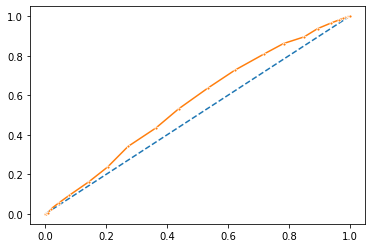

In [194]:
X = df['age'].values.reshape(-1,1)
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression().fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
sns.lineplot([0,1], [0,1], linestyle='--')
plt = sns.lineplot(fpr, tpr, marker='.')
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

With an AUC score of **.557**, this model performs barely better than a mean-based model, and is not effective at predicting `Winner` based on `age`.

**4c. `Winner` based on `age_dif`**

AUC: 0.581


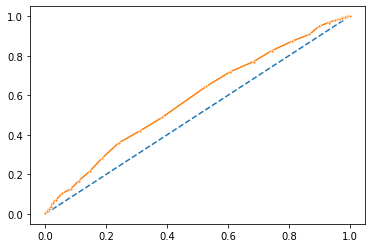

In [195]:
X = df[['age_dif']]
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression().fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
sns.lineplot([0,1], [0,1], linestyle='--')
plt = sns.lineplot(fpr, tpr, marker='.')
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

Even `age_dif` is not a good predictor of `Winner`.

AUC: 0.511


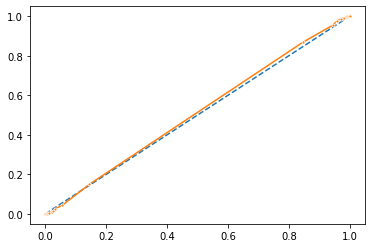

In [196]:
X = df[['total_title_bouts_dif']]
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression().fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
sns.lineplot([0,1], [0,1], linestyle='--')
plt = sns.lineplot(fpr, tpr, marker='.')
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

**4d. `Winner` vs. every column**

Just for fun, I will find out which single feature in the entire dataset would be the best predictor for `Winner`.

In [268]:
from pandas.api.types import is_numeric_dtype

auc = {}
df_numeric = [column for column in df.columns if is_numeric_dtype(df[column])]
df_numeric.remove('Winner')
df_numeric.remove('finish')

for column in df_numeric:
    df = df[df[column].notna()]
    X = df[[column]]
    y = df['Winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model = LogisticRegression().fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    auc_score = roc_auc_score(y_test, probs)

    auc[column] = auc_score
    
print(sorted(auc.items(), key=lambda x:x[1], reverse=True)[:20])

[('tot_str_landed_per_sec', 0.7825205715593982), ('sig_str_landed_per_sec', 0.7595501077586206), ('odds', 0.7051104555124917), ('sig_str_pct_bout', 0.6985699734996665), ('pass_per_sec', 0.6765734658735832), ('tot_str_attempted_per_sec', 0.6645924627519719), ('sig_str_attempted_per_sec', 0.6442616768725196), ('td_pct_bout', 0.6417973250288018), ('td_landed_per_sec', 0.6380696388712989), ('kd_per_sec', 0.6362177544965281), ('sub_attempts_per_sec', 0.5961925287356321), ('age_dif', 0.5914396537791585), ('age', 0.56295583394957), ('current_win_streak_dif', 0.5552562462118661), ('avg_TD_landed', 0.5473205786652479), ('current_win_streak', 0.5395330148954361), ('Reach_cms', 0.5367752161278999), ('win_by_Decision_Split', 0.5367101935371823), ('longest_win_streak_dif', 0.5357870869252873), ('avg_TD_landed_dif', 0.5314584430401966)]


It looks like the top 5 predictors for whether a fighter will win or not are `tot_str_landed_per_sec`, `odds`, `sig_str_landed_per_sec`, `sig_str_pct_bout`, and `tot_str_attempted_per_sec`. It makes particular sense for `odds` to be on this list, as these odds are generated by teams of professionals, so it follow that that their predictions would be accurate. Moreover, all the other features with high predictive power have to do with the fighter's performance *during* the fight, so they wouldn't be of much help in determining `Winner` before the fight begins. 

In [250]:
cols = [col for col in df.columns if (not col.startswith('country')) & 
        (not col.startswith('weight')) & 
        (not col.startswith('Stance')) &
        (not col.startswith('gender')) &
        (not col.startswith('finish')) &
        (not col.endswith('per_sec')) &
        (not col.endswith('bout')) &
        (not col == 'date') &
        (not col == 'fighter') &
        (not col == 'Winner') &
        (not col == 'finish') &
        (not 'time' in col)]
cols

['odds',
 'current_lose_streak',
 'current_win_streak',
 'draw',
 'avg_SIG_STR_landed',
 'avg_SIG_STR_pct',
 'avg_SUB_ATT',
 'avg_TD_landed',
 'avg_TD_pct',
 'longest_win_streak',
 'losses',
 'total_rounds_fought',
 'total_title_bouts',
 'win_by_Decision_Majority',
 'win_by_Decision_Split',
 'win_by_Decision_Unanimous',
 'win_by_KO/TKO',
 'win_by_Submission',
 'win_by_TKO_Doctor_Stoppage',
 'wins',
 'Height_cms',
 'Reach_cms',
 'Weight_lbs',
 'age',
 'better_rank',
 'win_pct',
 'adj_wins',
 'current_lose_streak_dif',
 'current_win_streak_dif',
 'longest_win_streak_dif',
 'wins_dif',
 'losses_dif',
 'total_rounds_fought_dif',
 'total_title_bouts_dif',
 'win_by_Submission_dif',
 'Height_cms_dif',
 'Reach_cms_dif',
 'age_dif',
 'avg_SIG_STR_landed_dif',
 'avg_SUB_ATT_dif',
 'avg_TD_landed_dif',
 'ko_dif',
 'adj_wins_dif']

In [212]:
tests = {}

for number in range(30):
    best_cols = []
    best_auc = 0
    
    for column in cols:
        auc_score = []
        best_cols.append(column)
    
        for number in range(50):
            X = df.loc[df[best_cols].notnull().all(axis=1)][best_cols]
            y = df.loc[df[best_cols].notnull().all(axis=1)]['Winner']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            model = LogisticRegression(max_iter=10000).fit(X_train, y_train)

            probs = model.predict_proba(X_test)
            probs = probs[:,1]
        
            auc_score.append(roc_auc_score(y_test, probs))
    
        mean = np.mean(auc_score)
        if mean > best_auc:
            best_auc = mean
        else:
            best_cols.remove(column)
    tests[best_auc] = best_cols
print(tests)

{0.723970971307291: ['odds', 'win_by_KO/TKO', 'finish_round', 'current_lose_streak_dif', 'age_dif'], 0.7217608348584066: ['odds', 'current_lose_streak', 'current_win_streak', 'losses', 'total_title_bouts', 'win_by_KO/TKO', 'current_win_streak_dif', 'Reach_cms_dif'], 0.7212654025661694: ['odds', 'current_lose_streak', 'current_win_streak', 'current_win_streak_dif'], 0.7244363696585207: ['odds', 'current_win_streak', 'finish_round', 'Reach_cms_dif'], 0.7232420588825037: ['odds', 'current_lose_streak', 'total_rounds_fought', 'finish_round'], 0.7236392732971589: ['odds', 'draw', 'losses'], 0.7216410858202594: ['odds', 'current_lose_streak', 'win_by_Submission_dif', 'age_dif'], 0.7222276840673543: ['odds', 'current_win_streak', 'Weight_lbs'], 0.7221834716862773: ['odds', 'current_win_streak', 'current_lose_streak_dif', 'losses_dif', 'Reach_cms_dif', 'age_dif'], 0.7217937432921785: ['odds', 'current_lose_streak', 'draw', 'win_by_Submission_dif'], 0.72193381565433: ['odds', 'current_lose_stre

In [249]:
keys = [key for key in tests.keys()]
keys.sort(reverse=True)

top5 = {key:value for key, value in tests.items() if key in keys[:5]}

top5_vals = [val for val in top5.values()]
top5_vals

from collections import Counter

counter = Counter(top5_vals[0])
for i in top5_vals[1:]: 
    counter.update(i)

counter.most_common()

[('odds', 5),
 ('finish_round', 5),
 ('current_win_streak', 3),
 ('Reach_cms_dif', 2),
 ('age_dif', 2),
 ('current_lose_streak', 2),
 ('total_title_bouts_dif', 2),
 ('win_by_Decision_Split', 1),
 ('longest_win_streak_dif', 1),
 ('total_rounds_fought_dif', 1),
 ('losses', 1),
 ('total_rounds_fought', 1),
 ('win_by_TKO_Doctor_Stoppage', 1),
 ('draw', 1),
 ('age', 1)]

In [259]:
auc_score = []
best_cols = ['odds']

for number in range(500):
    X = df.loc[df[best_cols].notnull().all(axis=1)][best_cols]
    y = df.loc[df[best_cols].notnull().all(axis=1)]['Winner']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = LogisticRegression(max_iter=10000).fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    probs = probs[:,1]
        
    auc_score.append(roc_auc_score(y_test, probs))
    mean = np.mean(auc_score)

mean

0.7198264680545752

In [262]:
auc_score = []
best_cols = ['age','age_dif']

for number in range(500):
    X = df.loc[df[best_cols].notnull().all(axis=1)][best_cols]
    y = df.loc[df[best_cols].notnull().all(axis=1)]['Winner']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = LogisticRegression(max_iter=10000).fit(X_train, y_train)

    probs = model.predict_proba(X_test)
    probs = probs[:,1]
        
    auc_score.append(roc_auc_score(y_test, probs))
    mean = np.mean(auc_score)

mean

0.5823376843195676

In [270]:
rf = RandomForestClassifier()

X_cols = [col for col in df_numeric if col != 'finish_round']
X = df[X_cols].notna()
y = df['finish_round']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = rf.fit(X_train, y_train)
model.score(X_test, y_test)

0.5690866510538641

In [271]:
df['finish_round'].value_counts(dropna=False)

3.0    2354
1.0    1098
2.0     608
5.0     178
4.0      30
Name: finish_round, dtype: int64

# 5. Conclusion <a id='5._Conclusion'></a>

Despite our best efforts to fit a model to the data, we were unsuccessful in our efforts to predict any sort of fight metric based on a fighter's age. Although our exploratory data analysis found a significant difference in `age` between several different fight metrics, a linear regression model based on `age` did not yield a better model compared to a simple model where we pick the mean every time. When it came to a classification model for `Winner`, `age` did not fare much better. In fact, it seems like the only pre-fight feature (that we have access to) that can predict the `Winner` of a fight is `odds`, which means the people in Las Vegas who are coming up with these `odds` are doing their jobs right. 

**Further work:** The dataset that we used only contained information from fights starting in 2010 and beyond. However, the UFC had its first fight in 1993, so our dataset was missing 17 years of data. It is possible that we could have build a more accurate model with this missing data. However, acquiring that missing data personally would take a lot of time and research. 